In [117]:
import pandas as pd
import numpy as np
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.models import Model, load_model
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib 
import matplotlib.pyplot as plt

In [123]:
df=pd.read_csv("datasets/htx_weather.csv")
df=df.dropna(axis=0)
df['RainTodayFlag']=df['rain_today'].apply(lambda x: 1 if x=='Yes' else 0)
df['RainTomorrowFlag']=df['rain_tomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

In [90]:
X=df[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 
      'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',  
      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTodayFlag']]
y = df[['RainTomorrowFlag']]
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [92]:
n_inputs=X_train.shape[1]
n_bottleneck=(round(float(n_inputs)))

In [93]:
visible = Input(shape=(n_inputs,), name='Input-Layer')

In [94]:
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

In [95]:
bottleneck = Dense(units=n_bottleneck, name='Bottleneck-Layer')(e)

In [96]:
d = Dense(units=n_inputs, name='Decoder-Layer')(bottleneck)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

In [97]:
output = Dense(units=n_inputs, activation='linear', name='Output-Layer')(d)

In [98]:
model = Model(inputs=visible, outputs=output, name='Autoencoder-Model')

In [99]:
model.compile(optimizer='adam', loss='mse')

In [100]:
print(model.summary())

Model: "Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 17)]              0         
                                                                 
 Encoder-Layer (Dense)       (None, 17)                306       
                                                                 
 Encoder-Layer-Normalization  (None, 17)               68        
  (BatchNormalization)                                           
                                                                 
 Encoder-Layer-Activation (L  (None, 17)               0         
 eakyReLU)                                                       
                                                                 
 Bottleneck-Layer (Dense)    (None, 17)                306       
                                                                 
 Decoder-Layer (Dense)       (None, 17)          

In [101]:
history = model.fit(X_train, X_train, epochs=10, batch_size=16, verbose=1, validation_data=(X_test, X_test))

Epoch 1/10
2821/2821 [==============================] - 9s 3ms/step - loss: 0.0302 - val_loss: 0.0037
Epoch 2/10
2821/2821 [==============================] - 7s 3ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 3/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 4/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 5/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0037 - val_loss: 8.3799e-04
Epoch 6/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0034 - val_loss: 8.5881e-04
Epoch 7/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0032 - val_loss: 8.7961e-04
Epoch 8/10
2821/2821 [==============================] - 8s 3ms/step - loss: 0.0031 - val_loss: 8.6763e-04
Epoch 9/10
2821/2821 [==============================] - 9s 3ms/step - loss: 0.0030 - val_loss: 5.9464e-04
Epoch 10/10
2821/2821 [==============================] - 9s 3m

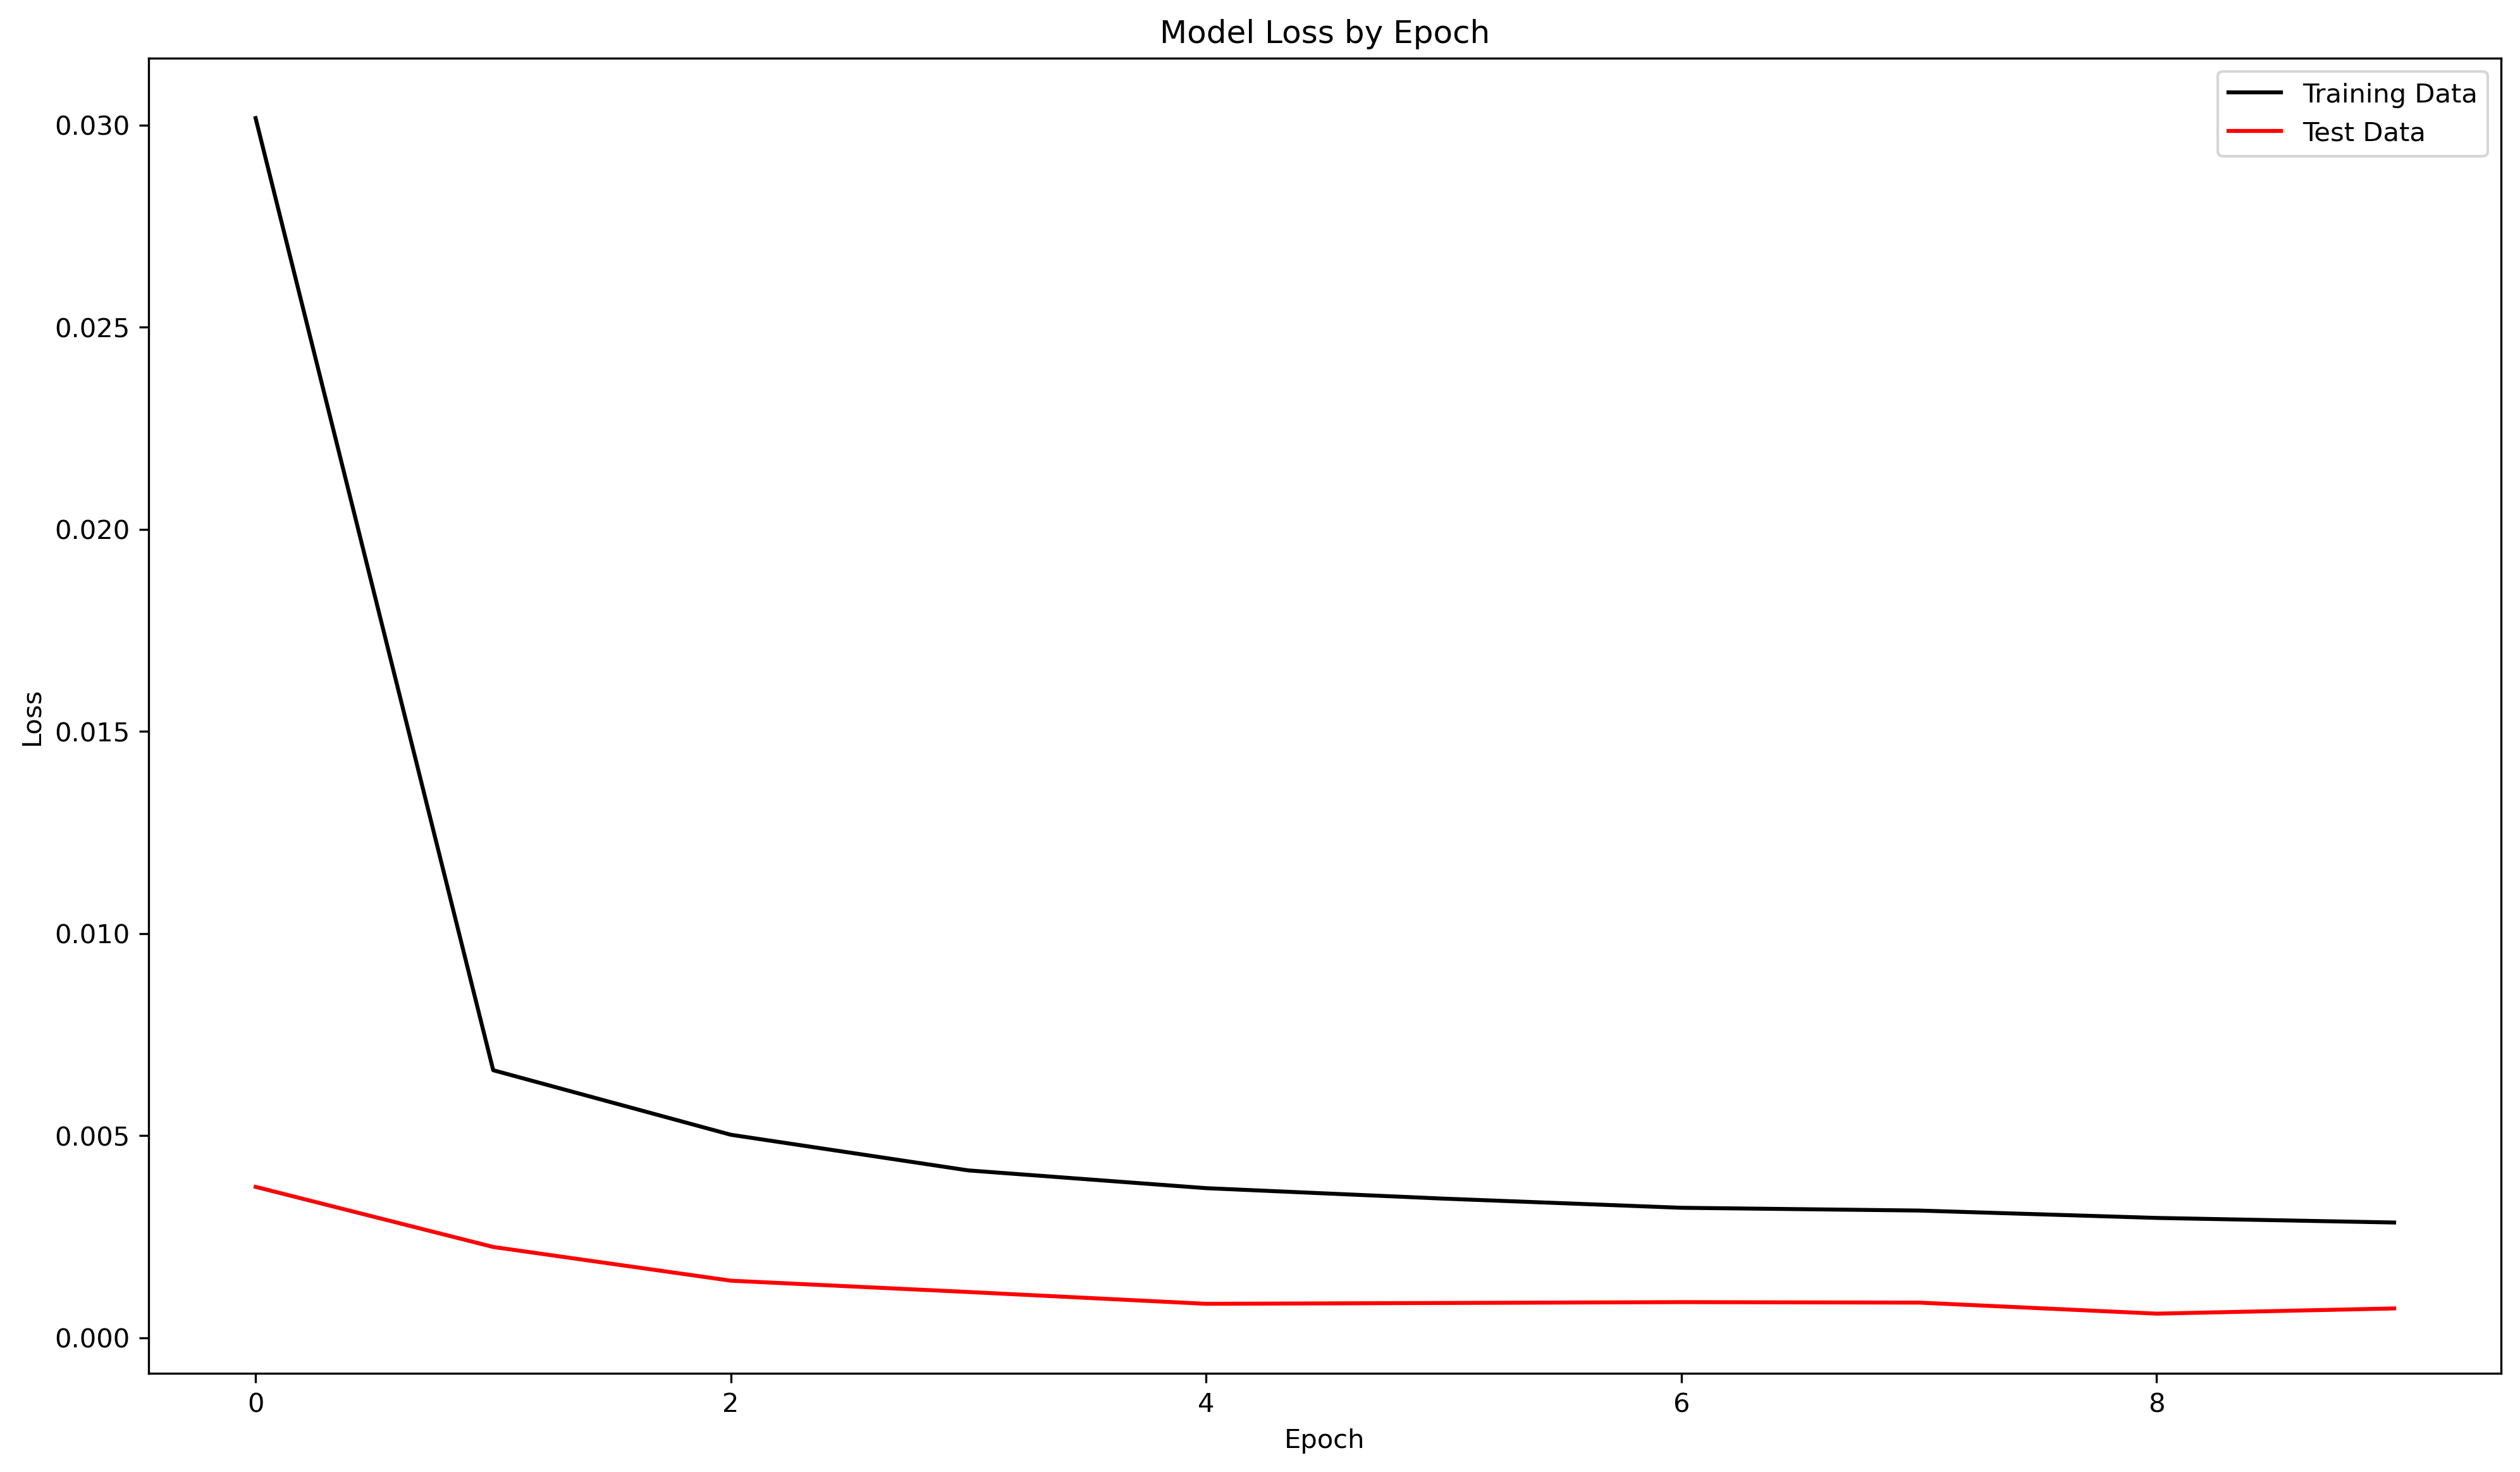

In [102]:
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend()

plt.show()

In [103]:
encoder = Model(inputs=visible, outputs=bottleneck)

In [104]:
encoder.compile(optimizer='adam', loss='mse')

In [105]:
encoder.save('encoder.h5')

In [106]:
encoder = load_model('encoder.h5')

In [107]:
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

353/353 [==============================] - 1s 1ms/step


In [111]:
model = LogisticRegression(solver='sag')
clf = model.fit(X_train_encoded, y_train)

D:\Anaconda3\envs\SmartSystems\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [112]:
pred_labels_tr = model.predict(X_train_encoded)
pred_labels_te = model.predict(X_test_encoded)

In [114]:
print('Intercept (Beta 0): ', clf.intercept_)
print('Slope (Beta 1): ', clf.coef_)

Intercept (Beta 0):  [-0.18349113]
Slope (Beta 1):  [[-1.186212   -0.15421985 -0.8104939  -2.1789072   3.5072129  -0.76610315
  -0.40345708 -0.80829275 -0.35013112  2.0128136   0.66837007 -0.60511863
   0.6284791   1.4183785  -1.8210636   0.97976196  1.4251009 ]]


In [118]:
score_te = model.score(X_test_encoded, y_test)
print('Accuracy score: ', score_te)
print(classification_report(y_test, pred_labels_te))

Accuracy score:  0.8534207727756115
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      8854
           1       0.71      0.54      0.61      2430

    accuracy                           0.85     11284
   macro avg       0.80      0.74      0.76     11284
weighted avg       0.84      0.85      0.85     11284



In [120]:
score_tr = model.score(X_train_encoded, y_train)
print('Accuracy score: ', score_tr)
print(classification_report(y_train, pred_labels_tr))

Accuracy score:  0.8488567883729174
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     35139
           1       0.72      0.52      0.60      9997

    accuracy                           0.85     45136
   macro avg       0.80      0.73      0.76     45136
weighted avg       0.84      0.85      0.84     45136

